# Ch3

In [1]:
from typing import *
import os
from glob import glob
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nptyping import NDArray
from IPython.display import display

# 型推定
from matplotlib.figure import Figure
from matplotlib.axes._subplots import Subplot

sns.set_style('whitegrid')
colors = ['#de3838', '#007bc3', '#ffd12a']
markers = ['o', 'x', ',']
%config InlineBackend.figure_formats = ['svg']

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)

cmap = sns.diverging_palette(255, 0, as_cmap=True)  # カラーパレットの定義

## 1次元グリッドワールド

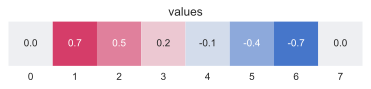

In [2]:
class Gridworld:
    def __init__(self, size: int = 8) -> None:
        self.size : int = size
        self.states : List[int] = list(range(size))
        self.actions : List[int] = [-1, 1]

        self.policy : Dict[Tuple[int, int], float] = {}  # (state, action)をkey、行動ポリシー確率をvalue
        for state in self.states:
            self.policy[(state, 1)] = 1/2
            self.policy[(state, -1)] = 1/2

        self.value : Dict[int, float] = {state: 0.0 for state in self.states}

    def move(self, state: int, action: int) -> Tuple[int, int]:
        """報酬と新しい状態を返却"""
        if state in (0, self.size-1):  # Terminal state
            return 0, state       # Reward, Next state

        new_state : int = state + action

        if new_state == 0:
            return 1, new_state   # Reward, Next state

        if new_state == self.size-1:
            return -1, new_state  # Reward, Next state

        return 0, new_state     # Reward, Next state


def show_values(world: Gridworld, subplot: Optional[Subplot] = None, title : str ='values') -> None:
    if subplot is None:
        fig : Figure = plt.figure(figsize=(world.size*0.8, 1.7))
        subplot : Subplot = fig.add_subplot(1, 1, 1)

    result : NDArray[(1, world.size), float] = np.zeros([1, world.size])
    for state in world.states:
        result[0][state] = world.value[state]
    sns.heatmap(result, cmap=cmap, square=True, cbar=False, yticklabels=[], annot=True, fmt='3.1f', ax=subplot).set_title(title)


def policy_eval(world: Gridworld, gamma: float = 1, delta: float = 0.01) -> None:
    """現在のポリシーπに対する状態価値関数v(s)を計算"""
    while True:
        delta_max : float = 0
        for state in world.states:
            new_value : float = 0
            for action in world.actions:
                reward, new_state = world.move(state, action)
                new_value += world.policy[(state, action)] * (reward + gamma * world.value[new_state])
            delta_max = max(delta_max, abs(world.value[state] - new_value))
            world.value[state] = new_value

        if delta_max < delta:
            break


def policy_update(world: Gridworld, gamma: float = 1.0) -> bool:
    """
    Greedyポリシーを用いて新しい行動ポリシーπ'を決定し置き換える。
    行動ポリシーが変化したかどうかを返却
    """
    update : bool = False
    for state in world.states:
        q_max : float = -10**10
        best_action : Optional[int] = None
        for action in world.actions:
            reward, new_state = world.move(state=state, action=action)
            q = reward + gamma * world.value[new_state]  # 行動-状態価値関数q(s, a)
            if q > q_max:
                q_max = q  
                best_action = action  # 行動-状態価値関数q(s, a)を最大とするactionを保存

        # 行動ポリシーが変化したか判定
        if world.policy[(state, best_action)] != 1:
            update = True
        # best_action以外のactionが選ばれる確率を0に設定
        for action in world.actions:
            world.policy[(state, action)] = 0
        world.policy[(state, best_action)] = 1

    return update



world : Gridworld = Gridworld(size=8)
policy_eval(world=world)
show_values(world=world)

p(1,  1) = 0
p(1, -1) = 1
p(2,  1) = 0
p(2, -1) = 1
p(3,  1) = 0
p(3, -1) = 1
p(4,  1) = 0
p(4, -1) = 1
p(5,  1) = 0
p(5, -1) = 1
p(6,  1) = 0
p(6, -1) = 1


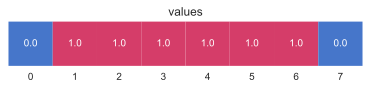

In [3]:
policy_update(world=world)
for (state, action), prob in world.policy.items():
    if state not in [0, 7]:
        print(f'p({state:d}, {action:2d}) = {prob}')

policy_eval(world=world)
show_values(world=world)

## 2次元グリッドワールド 

....

...

....

...



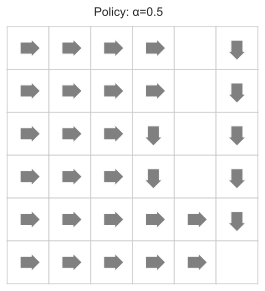

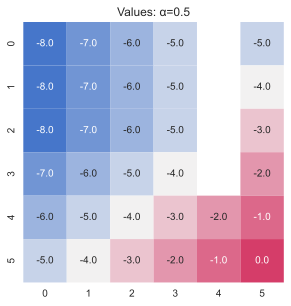

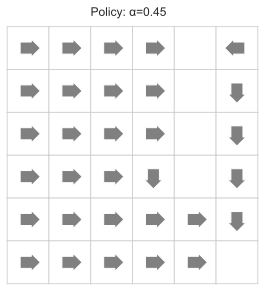

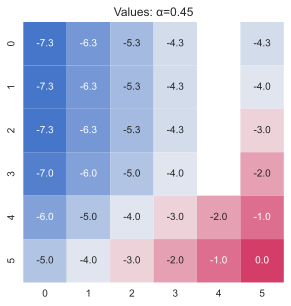

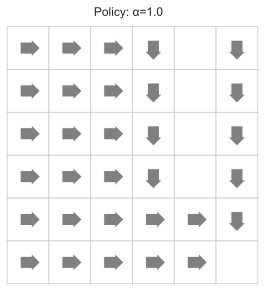

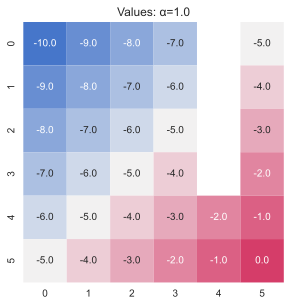

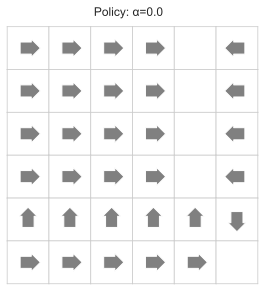

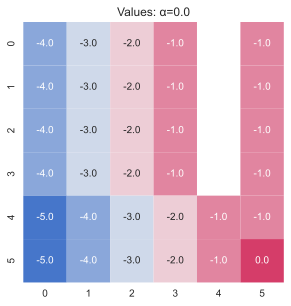

In [4]:
Coord = Tuple[int, int]

class Gridworld:
    def __init__(self, size: int = 6, traps: List[Coord] = [], alpha: float = 0.0) -> None:
        self.size : int = size
        self.traps : List[Coord] = traps
        self.alpha : float = alpha
        self.start : Coord = (0, 0)
        self.goal : Coord = (size-1, size-1)

        self.states : List[Coord] = [(x, y) for x in range(size) for y in range(size)]
        self.actions : List[Coord] = [(-1, 0), (0, -1), (1, 0), (0, 1)]  # (左, 上, 右, 下)に移動
        self.policy : Dict[Tuple[Coord, Coord], float] = {}  # 行動ポリシー確率
        for state in self.states:
            self.policy[state, self.actions[0]] = 0
            self.policy[state, self.actions[1]] = 0
            self.policy[state, self.actions[2]] = 1/2
            self.policy[state, self.actions[3]] = 1/2
        self.value : Dict[Coord, float] = {state: 0 for state in self.states}  # 状態価値関数

    def move(self, state: Coord, action: Coord) -> List[Tuple[float, int, Coord]]:
        """現在の状態、アクションを受けて、[(遷移確率, 報酬, 次の状態), ...]を返却"""
        if state == self.goal:
            return [(1.0, 0, state)]
        new_state : Coord = (state[0] + action[0], state[1] + action[1])
        if new_state not in self.states:
            return [(1.0, -1, state)]
        if new_state in self.traps:
            return [(self.alpha, -1, self.start), (1-self.alpha, -1, self.goal)]
        return [(1.0, -1, new_state)]


def show_values(world: Gridworld, subplot: Optional[Subplot] = None, title: str = 'Values'):
    if subplot is None:
        fig : Figure = plt.figure(figsize=(world.size*0.8, world.size*0.8))
        subplot : Subplot = fig.add_subplot(1, 1, 1)

    result : NDArray[(world.size, world.size), Optional[float]] = np.zeros([world.size, world.size])
    for (x, y) in world.states:
        if (x, y) in world.traps:
            result[y][x] = None
        else:
            result[y][x] = world.value[(x, y)]
    sns.heatmap(result, cmap=cmap, square=True, cbar=False, annot=True, fmt='3.1f', ax=subplot).set_title(title)


def show_policy(world: Gridworld, title: str = 'Policy') -> None:
    """行動ポリシーを矢印で可視化"""
    rotation : Dict[Coord, int] = {(-1, 0): 180, (0, -1): 90, (1, 0): 0, (0, 1): 270}
    fig : Figure = plt.figure(figsize=(world.size*0.75, world.size*0.75))
    fig.subplots_adjust(wspace=0, hspace=0, top=0.92)
    fig.suptitle(title)

    c : int = 0
    for y in range(world.size):
        for x in range(world.size):
            c += 1
            subplot : Subplot = fig.add_subplot(world.size, world.size, c)
            subplot.set_xticks([])
            subplot.set_yticks([])
            if (x, y) in world.traps or (x, y) == world.goal:
                direction : Optional[int] = None
            else:
                for action in world.actions:
                    if world.policy[((x, y), action)] == 1:
                        direction : Optional[int] = rotation[action]
            if direction is not None:
                bbox_props = dict(boxstyle='rarrow', fc='gray')
                subplot.text(0.5, 0.5, '     ', bbox=bbox_props, size=8, ha='center', va='center', rotation=direction)


def policy_eval(world: Gridworld, gamma: float = 1, delta: float = 0.01) -> None:
    """現在のポリシーπに対する状態価値関数v(s)を計算"""
    while True:
        delta_max : float = 0
        for state in world.states:
            new_value : float = 0
            for action in world.actions:
                results : List[Tuple[float, int, Coord]] = world.move(state, action)
                for prob, reward, new_state in results:
                    new_value += world.policy[(state, action)] * prob * (reward + gamma * world.value[new_state])
            delta_max = max(delta_max, abs(world.value[state] - new_value))
            world.value[state] = new_value  # 全ての状態sに対して状態価値関数v(s)を計算

        if delta_max < delta:
            break


def policy_update(world: Gridworld = world, gamma: float = 1.0) -> bool:
    """
    Greedyポリシーを用いて新しい行動ポリシーπ'を決定し置き換える。
    行動ポリシーが変化したかどうかを返却
    """
    update : bool = False
    for state in world.states:
        q_max : float = -10**10
        best_action : Optional[Coord] = None
        for action in world.actions:
            results : List[Tuple[float, int, Coord]] = world.move(state=state, action=action)
            q : int = 0
            for prob, reward, new_state in results:
                q += prob * (reward + gamma * world.value[new_state])
            if q > q_max:  # 行動-状態価値関数q(s, a)を最大とするactionを保存
                q_max = q
                best_action = action

        # 行動ポリシーが変化したか判定
        if world.policy[(state, best_action)] != 1:
            update = True
        # best_action以外のactionが選ばれる確率を0に設定
        for action in world.actions:
            world.policy[(state, action)] = 0
        world.policy[(state, best_action)] = 1
    
    return update


def policy_iteration(world: Gridworld) -> None:
    """ポリシー反復法を行う"""
    while True:
        print('.', end='')
        policy_eval(world=world)
        if not policy_update(world=world):
            print('\n')
            break


alpha_list : List[float] = [0.5, 0.45, 1.0, 0.0]
for alpha in alpha_list:
    world : Gridworld = Gridworld(size=6, traps=[(4, y) for y in range(4)], alpha=alpha)
    policy_iteration(world=world)
    show_policy(world=world, title=f'Policy: α={alpha}')
    show_values(world=world, title=f'Values: α={alpha}')

# 価値反復法

........................



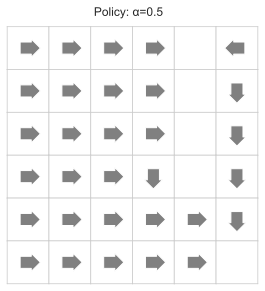

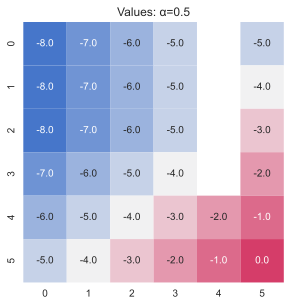

In [5]:
class Gridworld:
    def __init__(self, size: int = 6, traps: List[Coord] = [], alpha: float = 0.0) -> None:
        self.size : int = size
        self.traps : List[Coord] = traps
        self.alpha : float = alpha
        self.start : Coord = (0, 0)
        self.goal : Coord = (size-1, size-1)

        self.states : List[Coord] = [(x, y) for x in range(size) for y in range(size)]
        self.actions : List[Coord] = [(-1, 0), (0, -1), (1, 0), (0, 1)]  # (左, 上, 右, 下)に移動
        self.policy : Dict[Tuple[Coord, Coord], Optional[float]] = {(s, a): None for s in self.states for a in self.actions}  # 行動ポリシー確率
        self.value : Dict[Coord, float] = {state: 0 for state in self.states}  # 状態価値関数

    def move(self, state: Coord, action: Coord) -> List[Tuple[float, int, Coord]]:
        """現在の状態、アクションを受けて、[(遷移確率, 報酬, 次の状態), ...]を返却"""
        if state == self.goal:
            return [(1.0, 0, state)]
        new_state : Coord = (state[0] + action[0], state[1] + action[1])
        if new_state not in self.states:
            return [(1.0, -1, state)]
        if new_state in self.traps:
            return [(self.alpha, -1, self.start), (1-self.alpha, -1, self.goal)]
        return [(1.0, -1, new_state)]


def policy_update(world: Gridworld, state: Coord, gamma: float = 1.0) -> float:
    """
    指定された状態sに対して,Greedyポリシーを用いて新しい行動ポリシーπ'を決定し置き換える。
    行動-状態価値関数q(s, a)の最大値を返却
    """
    q_max : float = -10**10
    best_action : Optional[Coord] = None
    #  全てのアクションaについて、行動-状態価値関数q(s, a)を計算する
    for action in world.actions:
        results : List[Tuple[float, int, Coord]] = world.move(state=state, action=action)
        q : float = 0
        for prob, reward, new_state in results:
            q += prob * (reward + gamma * world.value[new_state])
        if q > q_max:
            q_max = q
            best_action = action  # 行動-状態価値関数q(s, a)を最大とするactionを保存
    # best_action以外のactionが選ばれる確率を0に設定
    for action in world.actions:
        world.policy[(state, action)] = 0
    world.policy[(state, best_action)] = 1

    return q_max


def value_iteration(world: Gridworld, delta: float = 0.01) -> None:
    while True:
        delta_max : float = 0
        print('.', end='')
        for state in world.states:
            new_value : float = policy_update(world=world, state=state)
            delta_max = max(delta_max, abs(world.value[state] - new_value))
            world.value[state] = new_value  # 状態価値関数の更新

        if delta_max < delta:
            print('\n')
            break


alpha : float = 0.5
world : Gridworld = Gridworld(size=6, traps=[(4, y) for y in range(4)], alpha=alpha)
value_iteration(world=world)
show_policy(world=world, title=f'Policy: α={alpha}')
show_values(world=world, title=f'Values: α={alpha}')

# 三目並べ

In [6]:
from enum import Enum, auto
from copy import deepcopy
import random

Board = List[List[int]]


class StateInfo(Enum):
    PLAYER1 = auto()
    PLAYER2 = auto()
    WIN1 = auto()
    WIN2 = auto()
    TIE = auto()


def flatten(array_2d: List[List[Any]]) -> List[int]:
    """2次元リストを1次元リストに変換

    UnitTests
    ---------
    >>> flatten(array_2d=[[1, 2], [3, 4, 5], [6]])
    [1, 2, 3, 4, 5]
    """
    array_1d : List[Any] = sum(array_2d, [])
    return array_1d


class State:
    def __init__(self, board: Board) -> None:
        self.board : Board = board
        self.info : Optional[StateInfo] = self._get_state_info(board=board)

    def __hash__(self) -> int:
        return hash(tuple(flatten(self.board)))

    def __eq__(self, other) -> bool:
        return self.board == other.board

    def __repr__(self) -> str:
        chars : Dict[int, str] = {0: '□ ', 1: '○ ', 2: '× '}
        result : str = ''
        for row in self.board:
            result += ''.join([chars[x] for x in row]) + '\n'
        return result

    def _get_state_info(self, board: Board) -> Optional[StateInfo]:
        """盤面の状態を確認する。不正な盤面であればNoneを返却"""
        num_circle : int = sum(map(lambda x: x == 1, flatten(board)))
        num_cross : int = sum(map(lambda x: x == 2, flatten(board)))
        if (num_circle != num_cross) and (num_circle != num_cross+1):
            return None
        game_over_lines : List[List[Tuple[int, int]]] = [[(col, row) for col in range(3)] for row in range(3)]  # 横ラインの勝利条件
        game_over_lines += [[(col, row) for row in range(3)] for col in range(3)]  # 縦ラインの勝利条件
        game_over_lines += [[(x, x) for x in range(3)], [(x, 2-x) for x in range(3)]]  # 斜めラインの勝利条件
        win1, win2 = False, False
        for line in game_over_lines:
            if all(map(lambda pos: board[pos[1]][pos[0]] == 1, line)):  # ○の勝利
                win1 = True
            if all(map(lambda pos: board[pos[1]][pos[0]] == 2, line)):  # ×の勝利
                win2 = True
        
        if win1 and win2:
            return None
        if win1:
            return StateInfo.WIN1
        if win2:
            return StateInfo.WIN2
        
        if sum(map(lambda x: x == 0, flatten(board))) == 0:  # 引き分け
            return StateInfo.TIE

        if num_circle == num_cross:
            return StateInfo.PLAYER1
        else:
            return StateInfo.PLAYER2


board : Board = [
    [2, 0, 0],
    [0, 2, 0],
    [0, 1, 1]]
state : State = State(board=board)
print(state)

× □ □ 
□ × □ 
□ ○ ○ 



In [13]:
class Agent:
    def __init__(self, player: int) -> None:
        self.player : int = player
        self.states : List[State] = []
        # 全ての取り得る盤面をstatesに保存
        rows : List[List[int]] = [[a, b, c] for a in range(3) for b in range(3) for c in range(3)]
        boards : List[Board] = [[a.copy(), b.copy(), c.copy()] for a in rows for b in rows for c in rows]
        for board in boards:
            state : State = State(board=board)
            # 盤面として存在しないもの、および相手の手番は破棄
            if (self.player == 1) and (state.info not in (None, StateInfo.PLAYER2)):
                self.states.append(state)
            if (self.player == 2) and (state.info not in (None, StateInfo.PLAYER1)):
                self.states.append(state)

        # 状態価値関数をvalueとするdict
        self.value : Dict[State, int] = {state: 0 for state in self.states}  
        # 行動ポリシーをvalueとするdict。ランダムなアクションで初期化
        self.policy : Dict[State, Optional[Tuple[int, int]]] = {}
        for state in self.states:
            if self._is_myturn(state=state):
                self.policy[state] = random.choice(self._get_actions(state=state))
            else:
                self.policy[state] = None  # 終了状態ではNone

    def put(self, state: State, pos: Tuple[int, int], player: int) -> State:
        """playerが位置posにマークした際に得られる状態を返却"""
        col, row = pos
        board : Board = deepcopy(state.board)
        board[row][col] = player
        return State(board=board)

    def move(self, state: State, pos: Tuple[int, int], opponent) -> Tuple[int, State]:
        """playerが位置posにマークした際に得られる報酬と次の状態を返却"""
        if not self._is_myturn(state=state):  # 終了状態
            return 0, state
        next_state : State = self.put(state=state, pos=pos, player=self.player)
        if self._is_won(state=next_state):  # 自分が勝利
            return 1, next_state
        if next_state.info == StateInfo.TIE:  # 引き分け
            return 0, next_state
        pos = opponent.policy[next_state]
        after_state : State = self.put(state=next_state, pos=pos, player=opponent.player)
        if self._is_lost(state=after_state):  # 相手が勝利
            return -1, after_state
        return 0, after_state  # 勝敗は決さず、次の手番の状態

    def _is_myturn(self, state: State) -> bool:
        """与えられた状態が自分の手番であるか"""
        if (self.player == 1) and (state.info == StateInfo.PLAYER1):
            return True
        if (self.player == 2) and (state.info == StateInfo.PLAYER2):
            return True
        return False

    def _is_won(self, state: State) -> bool:
        """与えられた状態が自分が勝った状態であるか"""
        if (self.player == 1) and (state.info == StateInfo.WIN1):
            return True
        if (self.player == 2) and (state.info == StateInfo.WIN2):
            return True
        return False
    
    def _is_lost(self, state: State) -> bool:
        """与えられた状態が自分が負けた状態であるか"""
        if (self.player == 1) and (state.info == StateInfo.WIN2):
            return True
        if (self.player == 2) and (state.info == StateInfo.WIN1):
            return True
        return False

    def _get_actions(self, state: State) -> List[Tuple[int, int]]:
        """与えられた状態において、空いている場所(□)のリストを返却"""
        actions : List[Tuple[int, int]] = [(col, row) for row in range(3) for col in range(3) if state.board[row][col] == 0]
        return actions

In [14]:
def policy_eval(agent: Agent, opponent: Agent, gamma: float = 1.0, delta: float = 0.01) -> None:
    while True:
        delta_max : float = 0
        for state in agent.states:
            reward, new_state = agent.move(state=state, pos=agent.policy[state], opponent=opponent)
            new_value : float = reward + gamma * agent.value[new_state]
            delta_max = max(delta_max, abs(agent.value[state] - new_value))
            agent.value[state] = new_value
        
        if delta_max < delta:
            break


def policy_update(agent: Agent, opponent: Agent, gamma: float = 1.0) -> bool:
    update : bool = False
    for state in agent.states:
        if not agent._is_myturn(state=state):
            continue
        
        q_max : float = -10**10
        best_pos : Optional[Tuple[int, int]] = None
        for pos in agent._get_actions(state=state):
            reward, new_state = agent.move(state=state, pos=pos, opponent=opponent)
            q : float = reward + gamma * agent.value[new_state]
            if q > q_max:
                q_max = q
                best_pos = pos
        
        if agent.policy[state] != best_pos:
            update = True
        agent.policy[state] = best_pos

    return update
    

def policy_iteration(agent: Agent, opponent: Agent) -> None:
    while True:
        print('.', end='')
        policy_eval(agent=agent, opponent=opponent)
        if not policy_update(agent=agent, opponent=opponent):
            break


agent1 : Agent = Agent(player=1)
agent2 : Agent = Agent(player=2)

for _ in range(6):
    policy_iteration(agent=agent1, opponent=agent2)
    policy_iteration(agent=agent2, opponent=agent1)
    print('')

........
........
......
.....
...
..


In [15]:
state : State = agent1.states[0]
initial : bool = True
while True:
    if initial:
        state = agent1.put(state=state, pos=random.choice(agent1._get_actions(state=state)), player=1)
        initial = False
    else:
        state = agent1.put(state=state, pos=agent1.policy[state], player=1)
    print(state)
    if state.info != StateInfo.PLAYER2:
        break

    state = agent1.put(state=state, pos=agent2.policy[state], player=2)
    print(state)
    if state.info != StateInfo.PLAYER1:
        break

print(state.info)

□ □ □ 
□ □ □ 
○ □ □ 

□ □ □ 
□ × □ 
○ □ □ 

○ □ □ 
□ × □ 
○ □ □ 

○ □ □ 
× × □ 
○ □ □ 

○ □ □ 
× × ○ 
○ □ □ 

○ × □ 
× × ○ 
○ □ □ 

○ × □ 
× × ○ 
○ ○ □ 

○ × □ 
× × ○ 
○ ○ × 

○ × ○ 
× × ○ 
○ ○ × 

StateInfo.TIE


In [17]:
state : State = agent1.states[0]
while True:
    state = agent1.put(state=state, pos=random.choice(agent1._get_actions(state=state)), player=1)
    print(state)
    if state.info != StateInfo.PLAYER2:
        break

    state = agent1.put(state=state, pos=agent2.policy[state], player=2)
    print(state)
    if state.info != StateInfo.PLAYER1:
        break

print(state.info)

□ □ □ 
□ □ ○ 
□ □ □ 

□ □ × 
□ □ ○ 
□ □ □ 

□ □ × 
□ □ ○ 
□ ○ □ 

× □ × 
□ □ ○ 
□ ○ □ 

× □ × 
□ ○ ○ 
□ ○ □ 

× × × 
□ ○ ○ 
□ ○ □ 

StateInfo.WIN2
